In [520]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy.stats import norm
from sklearn.metrics import r2_score

In [521]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_sept.csv", sep=",")

In [522]:
df.dropna(inplace=True)

In [523]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [524]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [525]:
cutoffs = pd.date_range(
    start="2024-09-30",   # first end-of-month
    end="2025-08-31",     # last end-of-month
    freq="ME"              # month-end
).to_list()

In [526]:
###resultat valg 2025
valg = {
    "Ap": [28.2],
    "Høyre": [14.6],
    "Frp": [23.9],
    "SV": [5.5],
    "Sp": [5.3],
    "KrF": [4.2],
    "Venstre": [3.8],
    "MDG": [4.7],
    "Rødt": [5.3],
#    "Andre": [3.6],
}


###resultat valg 2021
#valg = {
#    "Ap": [26.3],
#    "Høyre": [20.4],
#    "Frp": [11.6],
#    "SV": [7.6],
#    "Sp": [13.5],
#    "KrF": [3.8],
#    "Venstre": [4.6],
#    "MDG": [3.9],
#    "Rødt": [4.7],
##    "Andre": [3.6],
#}

###resultat valg 2017
#valg = {
#    "Ap": [27.4],
#    "Høyre": [25.0],
#    "Frp": [15.2],
#    "SV": [6.0],
#    "Sp": [10.3],
#    "KrF": [4.2],
#    "Venstre": [4.4],
#    "MDG": [3.2],
#    "Rødt": [2.4],
#    "Andre": [1.8],
#}



# Lage DataFrame
valg_df = pd.DataFrame(valg)
results = []
finals = []
y_true = valg_df.values.reshape(1, -1)[0]

In [527]:
parties= ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt']

In [528]:
for i, cutoff in enumerate(cutoffs):
    # Fit model on training set
    df_en=df[parties]

    df_ex = df[[c for c in df.columns if c not in df_en.columns and c not in ['Andre']]].iloc[1:]
        
    steps = len(cutoffs) - i +1

    ex_future=df_ex.loc[df_ex.index >= cutoff][:steps]
        
    df_en=df_en.loc[df_en.index <= cutoff]
    df_ex=df_ex.loc[df_ex.index <= cutoff]
            
    df_orig=df_en
    df_en_val = df_en.diff().dropna() 
            
    print(ex_future)
    print(cutoff)
    #model = VAR(df_en_val)
    model = VAR(endog=df_en_val, exog=df_ex)
    model_fitted = model.fit(maxlags=6, trend='n', method = 'ols')

    forecast_dates = pd.date_range(start=cutoff, periods=steps, freq='ME')
    
    last_actual_value = df_orig.iloc[-1]  # Last known actual data point
    print(last_actual_value)
    forecast = model_fitted.forecast(df_en_val.values[-model_fitted.k_ar:], steps=steps,  exog_future=ex_future)
            
    forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en_val.columns)
    forecast_df
    print(forecast_df)
    forecast_df = forecast_df.cumsum() + last_actual_value
    date_to_extract = "2025-09-30"
    estimate_row = forecast_df.loc[date_to_extract]
    y_pred = estimate_row.values.reshape(1, -1)[0]  
    #y_pred = (y_pred / y_pred.sum()) * 100

    # Compute error metric (MSE here)
    mse = median_absolute_error(y_true, y_pred)
    mse_pp = median_absolute_error(y_true, last_actual_value.values.reshape(1, -1)[0])
    
    results.append((cutoff,steps, mse, mse_pp))


            Ap_skandale  Hoyre_skandale  Frp_skandale  SV_skandale  \
Mnd                                                                  
2024-09-30            0               0             0            0   
2024-10-31            0               0             0            0   
2024-11-30            0               0             0            0   
2024-12-31            0               0             0            0   
2025-01-31            0               0             0            0   
2025-02-28            0               0             0            0   
2025-03-31            0               0             0            0   
2025-04-30            0               0             0            0   
2025-05-31            0               0             0            0   
2025-06-30            0               0             0            0   
2025-07-31            0               0             0            0   
2025-08-31            0               0             0            0   
2025-09-30          

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


            Ap_skandale  Hoyre_skandale  Frp_skandale  SV_skandale  \
Mnd                                                                  
2025-01-31            0               0             0            0   
2025-02-28            0               0             0            0   
2025-03-31            0               0             0            0   
2025-04-30            0               0             0            0   
2025-05-31            0               0             0            0   
2025-06-30            0               0             0            0   
2025-07-31            0               0             0            0   
2025-08-31            0               0             0            0   
2025-09-30            0               0             0            0   

            SP_skandale  KrF_skandale  Venstre_skandale  MDG_skandale  \
Mnd                                                                     
2025-01-31            0             0                 0             0   
2025-02-28

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31

Ap         28.5
Hoyre      18.7
Frp        20.6
SV          7.0
SP          5.7
KrF         3.6
Venstre     4.1
MDG         2.7
Rodt        5.3
Name: 2025-05-31 00:00:00, dtype: float64
                  Ap     Hoyre       Frp        SV        SP       KrF  \
2025-05-31  0.195240  0.793083 -0.051139 -1.525724  1.971052 -0.194494   
2025-06-30 -3.425471  0.342846  2.560566 -0.825186  2.430318 -0.306674   
2025-07-31 -0.474623 -0.093246  1.144479 -0.556380  1.206934 -0.466695   
2025-08-31 -1.998316  2.278745  1.100135 -1.323999  1.763666 -0.353230   
2025-09-30 -2.920732  2.613489  2.357725 -0.228044 -0.179365 -0.094881   

             Venstre       MDG      Rodt  
2025-05-31 -0.985438  0.378927 -0.108645  
2025-06-30 -0.563250 -0.904219  0.993619  
2025-07-31 -0.730299 -0.180760  0.257220  
2025-08-31 -0.746336 -0.323876 -0.375957  
2025-09-30 -0.769451 -0.836557  0.690747  
            Ap_skandale  Hoyre_skandale  Frp_skandale  SV_skandale  \
Mnd                                      

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [529]:
y_pred

array([25.09546085, 12.61007409, 24.30247596,  7.58837626,  6.81131897,
        3.89543975,  4.87403446,  4.7821084 ,  6.11484269])

In [530]:
results_df=pd.DataFrame(results, columns=["cutoff", "steps", "MSE", "mse_pp"])

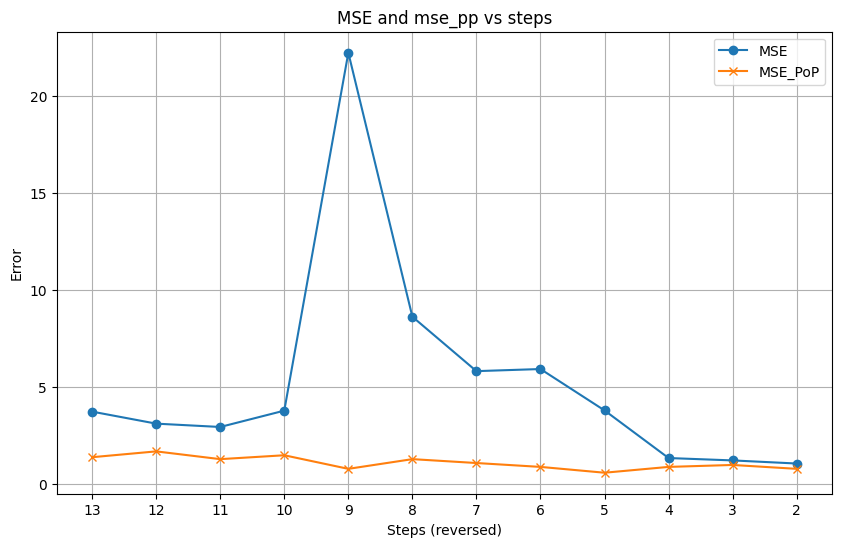

In [531]:
df_sorted = results_df.sort_values("steps", ascending=True)  # reverse lag order for x-axis
df_sorted
plt.figure(figsize=(10, 6))
plt.plot(df_sorted["steps"], df_sorted["MSE"], marker='o', label="MSE")
plt.plot(df_sorted["steps"], df_sorted["mse_pp"], marker='x', label="MSE_PoP")

plt.xlabel("Steps (reversed)")
plt.ylabel("Error")
plt.title("MSE and mse_pp vs steps")
plt.xticks(df_sorted["steps"])  # show all lag values on x-axis
plt.gca().invert_xaxis()      # reverse x-axis so largest lag is left
plt.legend()
plt.grid(True)
plt.show()

In [532]:
y_true

array([28.2, 14.6, 23.9,  5.5,  5.3,  4.2,  3.8,  4.7,  5.3])

In [533]:
y_pred

array([25.09546085, 12.61007409, 24.30247596,  7.58837626,  6.81131897,
        3.89543975,  4.87403446,  4.7821084 ,  6.11484269])

In [534]:
all_party_errors=[]
for i, cutoff in enumerate(cutoffs):
    # Fit model on training set
    df_en=df[parties]

    df_ex = df[[c for c in df.columns if c not in df_en.columns]].iloc[1:]
        
    steps = len(cutoffs) - i +1

    ex_future=df_ex.loc[df_ex.index >= cutoff][:steps]
        
    df_en=df_en.loc[df_en.index <= cutoff]
    df_ex=df_ex.loc[df_ex.index <= cutoff]
            
    df_orig=df_en
    df_en_val = df_en.diff().dropna() 
            
    #print(ex_future)
    #print(cutoff)
    #model = VAR(df_en_val)
    model = VAR(endog=df_en_val, exog=df_ex)
    model_fitted = model.fit(maxlags=2, trend='n', method = 'ols')

    forecast_dates = pd.date_range(start=cutoff, periods=steps, freq='ME')
            
    last_actual_value = df_orig.iloc[-1]  # Last known actual data point
    #print(last_actual_value)
    forecast = model_fitted.forecast(df_en_val.values[-model_fitted.k_ar:], steps=steps,  exog_future=ex_future)
            
    forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en_val.columns)
    
    forecast_df = forecast_df.cumsum() + last_actual_value
    date_to_extract = "2025-09-30"
    estimate_row = forecast_df.loc[date_to_extract]
    print(estimate_row)
    y_pred = estimate_row.values.reshape(1, -1)[0]  
    #y_pred = (y_pred / y_pred.sum()) * 96
    # Compute per-party errors
    for idx, party in enumerate(parties):
        error_pred = median_absolute_error([y_true[idx]], [y_pred[idx]])
        error_baseline = median_absolute_error([y_true[idx]], [last_actual_value.values[idx]])
        relative_error_pred=error_pred/y_true[idx]
        relative_error_baseline=error_baseline/y_true[idx]
        
        all_party_errors.append({
            "cutoff": cutoff,
            "party": party,
            "steps": steps,
            "last_pop": last_actual_value.values[idx],
            "model_est": y_pred[idx],
            "actual_election_result": y_true[idx],
            "error_forecast": error_pred,
            "error_baseline": error_baseline,
            "relative_error_forecast": relative_error_pred,
            "relative_error_baseline": relative_error_baseline
        })
    

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31

Ap         22.131527
Hoyre      20.889022
Frp        21.115777
SV          4.131190
SP         10.420031
KrF         6.147971
Venstre     4.051594
MDG         0.885585
Rodt        8.331746
Name: 2025-09-30 00:00:00, dtype: float64
Ap         18.247479
Hoyre      19.256861
Frp        24.579689
SV          4.666394
SP         11.107282
KrF         5.429392
Venstre     5.253084
MDG         1.942349
Rodt        8.182354
Name: 2025-09-30 00:00:00, dtype: float64
Ap         18.966903
Hoyre      15.006879
Frp        27.460237
SV          4.342180
SP         11.350441
KrF         4.941115
Venstre     5.023221
MDG         2.353446
Rodt        8.310569
Name: 2025-09-30 00:00:00, dtype: float64
Ap         10.709699
Hoyre      10.510203
Frp        38.675154
SV          7.413854
SP          7.026230
KrF         6.191695
Venstre     5.747970
MDG         2.474931
Rodt        8.566455
Name: 2025-09-30 00:00:00, dtype: float64
Ap         93.054223
Hoyre      49.487106
Frp        -0.807918
SV        -11

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
C:\Users\jens.nilsen\python\WPy64-31

In [535]:
y_pred

array([26.35925644, 10.88007731, 22.06082175,  7.32509017,  6.46689466,
        4.58624901,  4.87538108,  5.21406946,  7.21248805])

In [536]:
df_party_errors = pd.DataFrame(all_party_errors)

In [537]:
df_party_errors["better_than_baseline"] = (
    round(df_party_errors["error_forecast"],1) <= round(df_party_errors["error_baseline"],1)
)
df_party_errors["better_than_baseline_relative"] = (
    round(df_party_errors["relative_error_forecast"],1) <= round(df_party_errors["relative_error_baseline"],1)
)

In [538]:
df_party_errors.to_csv('relative.csv')

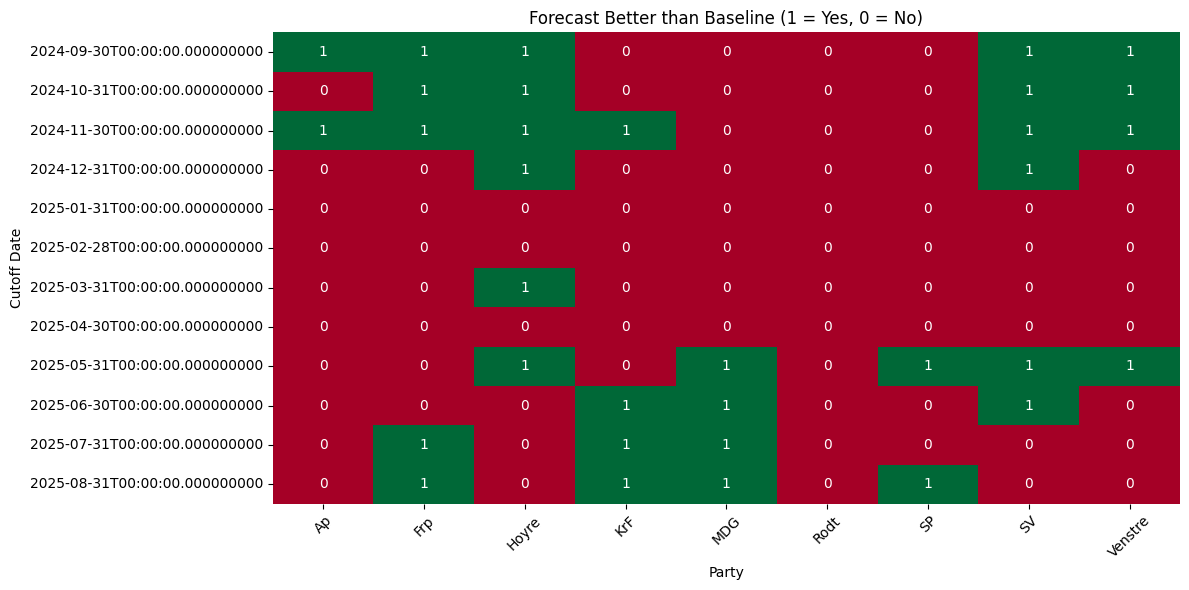

In [539]:
heatmap_data = df_party_errors.pivot(
    index="cutoff", columns="party", values="better_than_baseline_relative"
).astype(int)

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="RdYlGn", cbar=False)
plt.title("Forecast Better than Baseline (1 = Yes, 0 = No)")
plt.xlabel("Party")
plt.ylabel("Cutoff Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [540]:
forecast_df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
2025-08-31,26.000576,13.412877,21.483472,7.596964,6.710029,3.868597,4.707941,4.726603,6.822193
2025-09-30,26.359256,10.880077,22.060822,7.325090,6.466895,4.586249,4.875381,5.214069,7.212488


In [541]:
y_true

array([28.2, 14.6, 23.9,  5.5,  5.3,  4.2,  3.8,  4.7,  5.3])

In [542]:
last_actual_value

Ap         27.3
Hoyre      15.3
Frp        21.2
SV          6.3
SP          6.2
KrF         4.6
Venstre     4.2
MDG         4.3
Rodt        6.1
Name: 2025-08-31 00:00:00, dtype: float64

In [543]:
df_party_errors.better_than_baseline_relative.sum()/(12*9)

0.3055555555555556

In [544]:
df_party_errors[df_party_errors.cutoff=='2025-08-31']

,cutoff,party,steps,last_pop,model_est,actual_election_result,error_forecast,error_baseline,relative_error_forecast,relative_error_baseline,better_than_baseline,better_than_baseline_relative
99,2025-08-31,Ap,2,27.3,26.359256,28.2,1.840744,0.9,0.065275,0.031915,False,False
100,2025-08-31,Hoyre,2,15.3,10.880077,14.6,3.719923,0.7,0.254789,0.047945,False,False
101,2025-08-31,Frp,2,21.2,22.060822,23.9,1.839178,2.7,0.076953,0.112971,True,True
102,2025-08-31,SV,2,6.3,7.325090,5.5,1.825090,0.8,0.331835,0.145455,False,False
103,2025-08-31,SP,2,6.2,6.466895,5.3,1.166895,0.9,0.220169,0.169811,False,True
104,2025-08-31,KrF,2,4.6,4.586249,4.2,0.386249,0.4,0.091964,0.095238,True,True
105,2025-08-31,Venstre,2,4.2,4.875381,3.8,1.075381,0.4,0.282995,0.105263,False,False
106,2025-08-31,MDG,2,4.3,5.214069,4.7,0.514069,0.4,0.109376,0.085106,False,True
107,2025-08-31,Rodt,2,6.1,7.212488,5.3,1.912488,0.8,0.360847,0.150943,False,False


In [545]:
df_party_errors

,cutoff,party,steps,last_pop,model_est,actual_election_result,error_forecast,error_baseline,relative_error_forecast,relative_error_baseline,better_than_baseline,better_than_baseline_relative
0,2024-09-30,Ap,13,20.6,22.131527,28.2,6.068473,7.6,0.215194,0.269504,True,True
1,2024-09-30,Hoyre,13,24.6,20.889022,14.6,6.289022,10.0,0.430755,0.684932,True,True
2,2024-09-30,Frp,13,18.9,21.115777,23.9,2.784223,5.0,0.116495,0.209205,True,True
3,2024-09-30,SV,13,9.0,4.131190,5.5,1.368810,3.5,0.248875,0.636364,True,True
4,2024-09-30,SP,13,6.0,10.420031,5.3,5.120031,0.7,0.966044,0.132075,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
103,2025-08-31,SP,2,6.2,6.466895,5.3,1.166895,0.9,0.220169,0.169811,False,True
104,2025-08-31,KrF,2,4.6,4.586249,4.2,0.386249,0.4,0.091964,0.095238,True,True
105,2025-08-31,Venstre,2,4.2,4.875381,3.8,1.075381,0.4,0.282995,0.105263,False,False
106,2025-08-31,MDG,2,4.3,5.214069,4.7,0.514069,0.4,0.109376,0.085106,False,True


In [546]:
df=df_party_errors

In [547]:
rod_blokk = ["Ap", "SV", "SP", "Rodt", "MDG"]
bla_blokk = ["Hoyre", "Frp", "Venstre", "KrF"]

def blokk(party):
    if party in rod_blokk:
        return "Rød"
    elif party in bla_blokk:
        return "Blå"
    else:
        return "Andre"

df["blokk"] = df["party"].apply(blokk)

# aggreger per cutoff + blokk
agg = (
    df.groupby(["cutoff", "blokk"])
    .agg(
        last_pop=("last_pop", "sum"),
        model_est=("model_est", "sum"),
        actual=("actual_election_result", "sum"),
    )
    .reset_index()
)

# legg til feil-metrikker på samme måte som du gjorde for partiene
agg["error_forecast"] = (
    (agg["model_est"] - agg["actual"]).abs()
)
agg["error_baseline"] = (
    (agg["last_pop"] - agg["actual"]).abs()
)

agg["relative_error_forecast"] = agg["error_forecast"] / agg["actual"]
agg["relative_error_baseline"] = agg["error_baseline"] / agg["actual"]

agg["better_than_baseline"] = agg["error_forecast"] < agg["error_baseline"]
agg["better_than_baseline_relative"] = (
    agg["relative_error_forecast"] < agg["relative_error_baseline"]
)


In [548]:
agg

,cutoff,blokk,last_pop,model_est,actual,error_forecast,error_baseline,relative_error_forecast,relative_error_baseline,better_than_baseline,better_than_baseline_relative
0,2024-09-30,Blå,51.5,52.204365,46.5,5.704365,5.0,0.122675,0.107527,False,False
1,2024-09-30,Rød,44.5,45.900079,49.0,3.099921,4.5,0.063264,0.091837,True,True
2,2024-10-31,Blå,52.5,54.519026,46.5,8.019026,6.0,0.172452,0.129032,False,False
3,2024-10-31,Rød,43.9,44.145858,49.0,4.854142,5.1,0.099064,0.104082,True,True
4,2024-11-30,Blå,52.6,52.431452,46.5,5.931452,6.1,0.127558,0.131183,True,True
5,2024-11-30,Rød,43.6,45.323539,49.0,3.676461,5.4,0.075030,0.110204,True,True
6,2024-12-31,Blå,55.8,61.125022,46.5,14.625022,9.3,0.314517,0.200000,False,False
7,2024-12-31,Rød,40.8,36.191169,49.0,12.808831,8.2,0.261405,0.167347,False,False
8,2025-01-31,Blå,54.2,42.873932,46.5,3.626068,7.7,0.077980,0.165591,True,True
9,2025-01-31,Rød,41.9,53.373885,49.0,4.373885,7.1,0.089263,0.144898,True,True


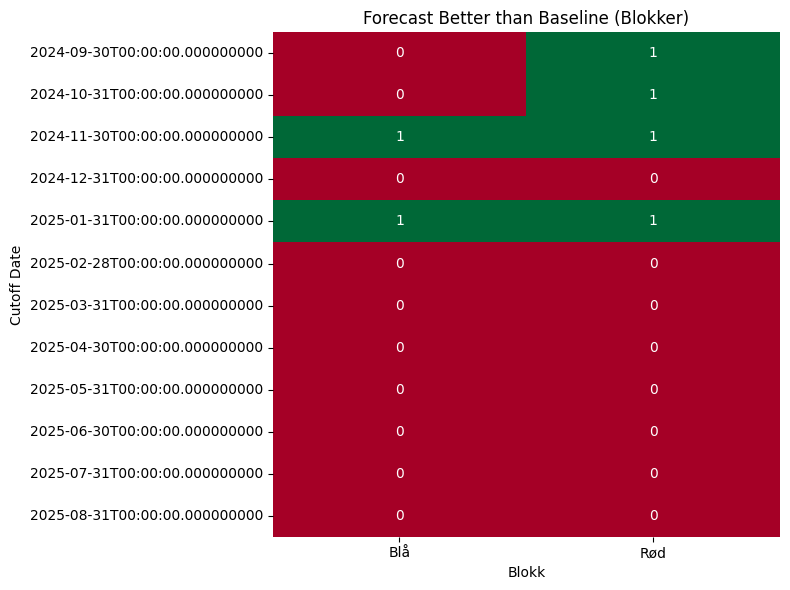

In [549]:
import seaborn as sns
import matplotlib.pyplot as plt

# bruk blokktabellen 'agg' fra forrige steg
heatmap_data_blokk = (
    agg.pivot(index="cutoff", columns="blokk", values="better_than_baseline_relative")
    .astype(int)
)

plt.figure(figsize=(8, 6))
sns.heatmap(
    heatmap_data_blokk,
    annot=True,
    fmt="d",
    cmap="RdYlGn",
    cbar=False
)

plt.title("Forecast Better than Baseline (Blokker)")
plt.xlabel("Blokk")
plt.ylabel("Cutoff Date")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
